In [1]:
import pandas as pd
from os import path
import matplotlib.pyplot as plt
from scipy import signal, interpolate
import numpy as np
import folium
from sklearn.model_selection import train_test_split


In [133]:
source_path = r"C:\Users\joses\Mi unidad\TRABAJO\49_profile_estimation\TRABAJO\experimental\bus_913\ordinal_regression"

win_len = 500
subtract_g = True
fs_acc = 100 # sps

speed_stopped_th = 1. # m/s
speed_tol = 0.01 # m/s
vib_features_tol = {'AccelerometerUncalibrated_z': 2./10,
                    'GyroscopeUncalibrated_x': .05/10,
                    'GyroscopeUncalibrated_y': .3/10
                    }

n_vib_features = len(vib_features_tol.keys())

# Data Extraction

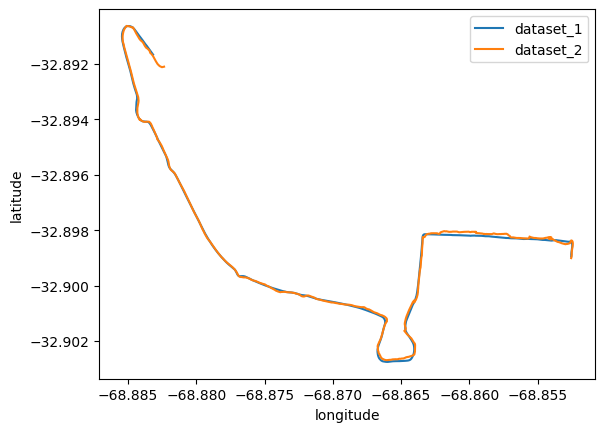

In [134]:
# Dataset 1
i_ini, i_fin = 60, 800 # s
vib_orig_df_1 = {vib_feature: None for vib_feature in vib_features_tol.keys()}
for vib_feature in vib_features_tol.keys():
    filename = vib_feature.split('_')[0]
    vib_orig_df_1[vib_feature] = pd.read_csv(path.join(source_path, f"913_1/{filename}.csv")).iloc[i_ini*fs_acc:i_fin*fs_acc, :].reset_index()
    if subtract_g and filename[:3] == 'Acc':
        vib_orig_df_1[vib_feature]['z'] = vib_orig_df_1[vib_feature]['z'] - 9.81
loc_orig_df_1 = pd.read_csv(path.join(source_path, "913_1/Location.csv")).iloc[i_ini:i_fin, :].reset_index()
loc_orig_df_1 = loc_orig_df_1.loc[loc_orig_df_1['speed'] > speed_stopped_th].reset_index()

# Dataset 2
i_ini, i_fin = 0, 800 # s
vib_orig_df_2 = {vib_feature: None for vib_feature in vib_features_tol.keys()}
for vib_feature in vib_features_tol.keys():
    filename = vib_feature.split('_')[0]
    vib_orig_df_2[vib_feature] = pd.read_csv(path.join(source_path, f"913_2/{filename}.csv")).iloc[i_ini*fs_acc:i_fin*fs_acc, :].reset_index()
    if subtract_g and filename[:3] == 'Acc':
        vib_orig_df_2[vib_feature]['z'] = vib_orig_df_2[vib_feature]['z'] - 9.81
loc_orig_df_2 = pd.read_csv(path.join(source_path, "913_2/Location.csv")).iloc[i_ini:i_fin, :].reset_index()
loc_orig_df_2 = loc_orig_df_2.loc[loc_orig_df_2['speed'] > speed_stopped_th].reset_index()

plt.plot(loc_orig_df_1['longitude'], loc_orig_df_1['latitude'], label='dataset_1')
plt.plot(loc_orig_df_2['longitude'], loc_orig_df_2['latitude'], label='dataset_2')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.legend()
plt.show()

## Raw Visualization

Text(0.5, 0, 'time (s)')

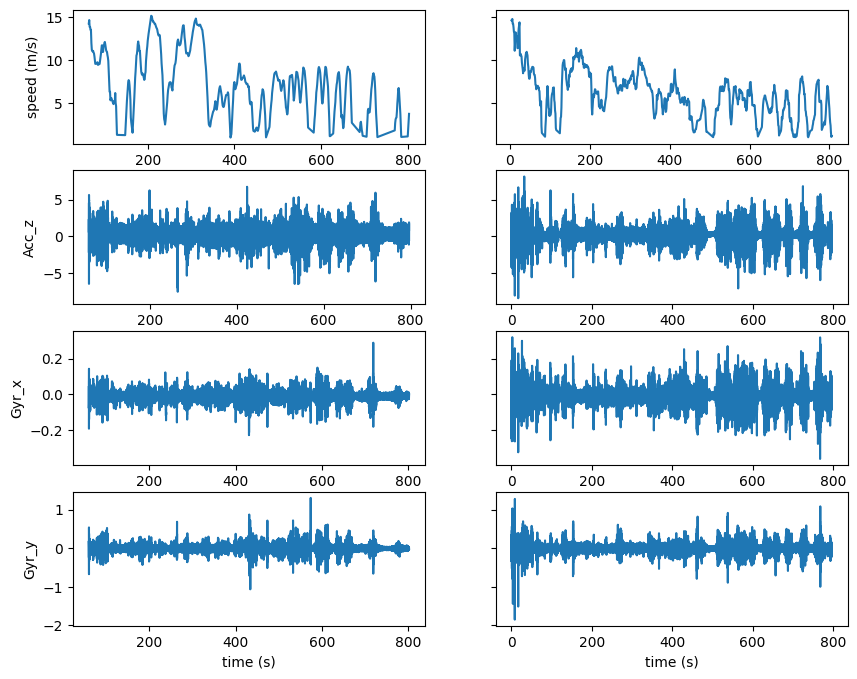

In [135]:
fig, ax = plt.subplots(n_vib_features+1, 2, sharey='row', figsize=(10,2+2*n_vib_features))

ax[0,0].plot(loc_orig_df_1['seconds_elapsed'], loc_orig_df_1['speed'])
ax[0,1].plot(loc_orig_df_2['seconds_elapsed'], loc_orig_df_2['speed'])
ax[0,0].set_ylabel('speed (m/s)')

for i, vib_feature in enumerate(vib_features_tol.keys()):
    ax[i+1, 0].plot(vib_orig_df_1[vib_feature]['seconds_elapsed'], vib_orig_df_1[vib_feature][vib_feature.split('_')[-1]])
    ax[i+1, 1].plot(vib_orig_df_2[vib_feature]['seconds_elapsed'], vib_orig_df_2[vib_feature][vib_feature.split('_')[-1]])
    ax[i+1, 0].set_ylabel(vib_feature.split('_')[0][:3] + '_' + vib_feature.split('_')[-1])
ax[i+1, 0].set_xlabel('time (s)')
ax[i+1, 1].set_xlabel('time (s)')

# Feature extraction

In [136]:
def rms(arr):
    return np.sqrt(np.mean(arr**2))


vib_feat_df_1, vib_feat_df_2 = {}, {}
for i, vib_feature in enumerate(vib_features_tol.keys()):
    vib_feat_df_1.update({vib_feature: 
                          pd.DataFrame(data=np.vstack((vib_orig_df_1[vib_feature]['seconds_elapsed'], 
                                                       vib_orig_df_1[vib_feature][vib_feature.split('_')[-1]].rolling(win_len).apply(rms).values)).T, 
                                                       columns=['seconds_elapsed', vib_feature]).reset_index()})
    vib_feat_df_2.update({vib_feature: 
                          pd.DataFrame(data=np.vstack((vib_orig_df_2[vib_feature]['seconds_elapsed'], 
                                                       vib_orig_df_2[vib_feature][vib_feature.split('_')[-1]].rolling(win_len).apply(rms).values)).T, 
                                                       columns=['seconds_elapsed', vib_feature]).reset_index()})


Text(0.5, 0, 'time (s)')

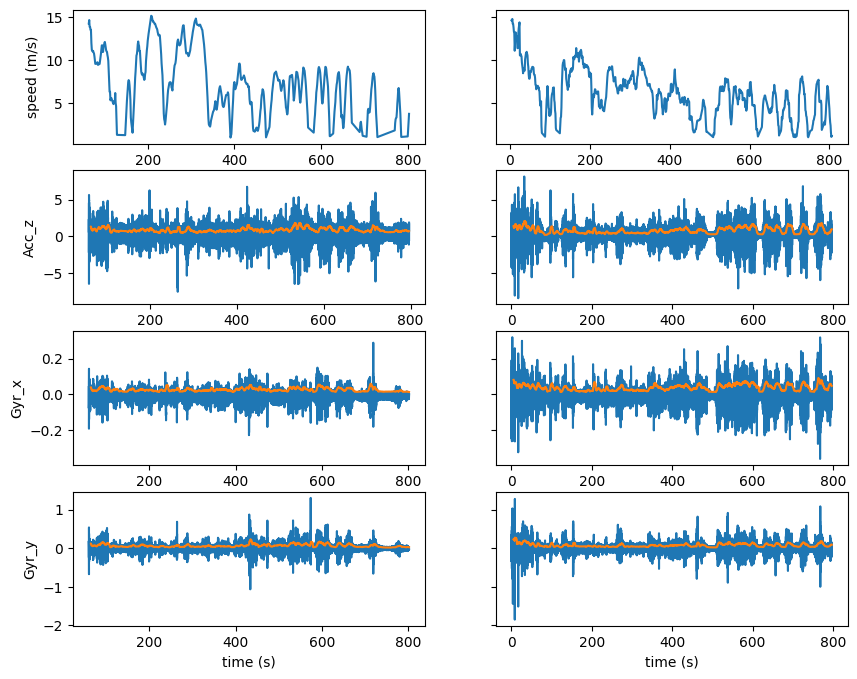

In [137]:
fig, ax = plt.subplots(n_vib_features+1, 2, sharey='row', figsize=(10,2+2*n_vib_features))

ax[0,0].plot(loc_orig_df_1['seconds_elapsed'], loc_orig_df_1['speed'])
ax[0,1].plot(loc_orig_df_2['seconds_elapsed'], loc_orig_df_2['speed'])
ax[0,0].set_ylabel('speed (m/s)')
for i, vib_feature in enumerate(vib_features_tol.keys()):
    ax[i+1, 0].plot(vib_orig_df_1[vib_feature]['seconds_elapsed'], vib_orig_df_1[vib_feature][vib_feature.split('_')[-1]])
    ax[i+1, 0].plot(vib_feat_df_1[vib_feature]['seconds_elapsed'], vib_feat_df_1[vib_feature][vib_feature])
    ax[i+1, 1].plot(vib_orig_df_2[vib_feature]['seconds_elapsed'], vib_orig_df_2[vib_feature][vib_feature.split('_')[-1]])
    ax[i+1, 1].plot(vib_feat_df_2[vib_feature]['seconds_elapsed'], vib_feat_df_2[vib_feature][vib_feature])
    ax[i+1, 0].set_ylabel(vib_feature.split('_')[0][:3] + '_' + vib_feature.split('_')[-1])
ax[i+1, 0].set_xlabel('time (s)')
ax[i+1, 1].set_xlabel('time (s)')


### Scatter analysis

#### Low frequency

Text(0.5, 0, 'time (s)')

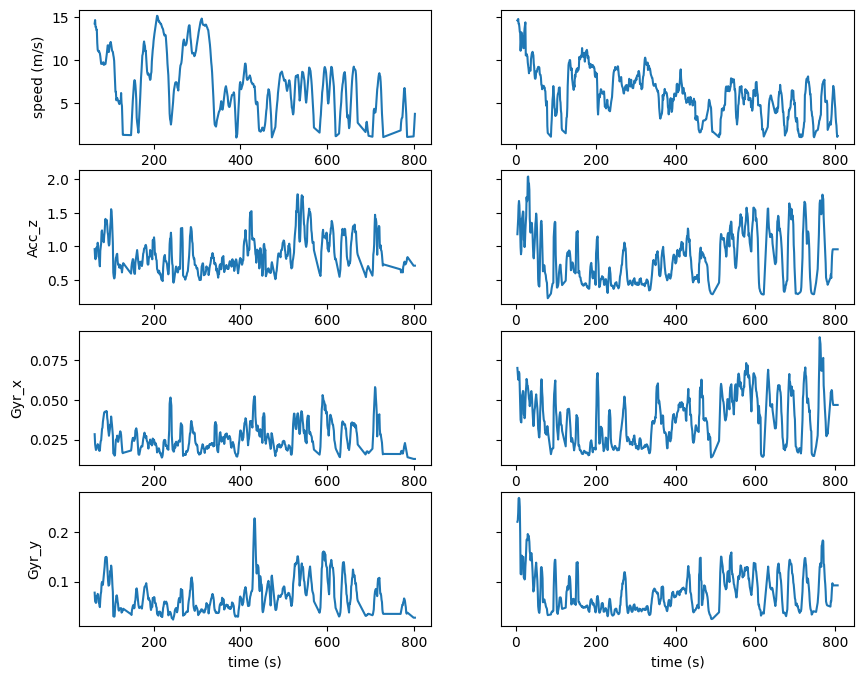

In [138]:
features_lf_1, features_lf_2 = loc_orig_df_1.loc[:,:], loc_orig_df_2.loc[:,:]

for i, vib_feature in enumerate(vib_features_tol.keys()):
    features_lf_1[vib_feature] = np.interp(x=loc_orig_df_1['seconds_elapsed'], 
                                           xp=vib_feat_df_1[vib_feature]['seconds_elapsed'].values-((win_len/fs_acc)/2), 
                                           fp=vib_feat_df_1[vib_feature][vib_feature])
    features_lf_1 = features_lf_1.drop(columns=['level_0']).reset_index()
    features_lf_2[vib_feature] = np.interp(x=loc_orig_df_2['seconds_elapsed'], 
                                           xp=vib_feat_df_2[vib_feature]['seconds_elapsed'].values-((win_len/fs_acc)/2), 
                                           fp=vib_feat_df_2[vib_feature][vib_feature])
    features_lf_2 = features_lf_2.drop(columns=['level_0']).reset_index()


def short_label(vib_feature):
    return vib_feature.split('_')[0][:3] + '_' + vib_feature.split('_')[-1]


fig, ax = plt.subplots(n_vib_features+1, 2, sharey='row', figsize=(10,2+2*n_vib_features))
ax[0,0].plot(loc_orig_df_1['seconds_elapsed'], loc_orig_df_1['speed'])
ax[0,1].plot(loc_orig_df_2['seconds_elapsed'], loc_orig_df_2['speed'])
ax[0,0].set_ylabel('speed (m/s)')
for i, vib_feature in enumerate(vib_features_tol.keys()):
    ax[i+1, 0].plot(features_lf_1['seconds_elapsed'], features_lf_1[vib_feature])
    ax[i+1, 1].plot(features_lf_2['seconds_elapsed'], features_lf_2[vib_feature])
    ax[i+1, 0].set_ylabel(short_label(vib_feature))
ax[i+1, 0].set_xlabel('time (s)')
ax[i+1, 1].set_xlabel('time (s)')

### Location matching

In [139]:
from scipy.spatial.distance import cdist


# Extract coordinates as arrays
coords_orig = loc_orig_df_1[['latitude', 'longitude']].values
coords_dest = loc_orig_df_2[['latitude', 'longitude']].values

# Compute pairwise distances
distances = cdist(coords_orig, coords_dest, metric='euclidean')

# Find the nearest point for each origin point
nearest_indices = distances.argmin(axis=1)
nearest_distances = distances.min(axis=1)

# Build a dictionary of time matches
time_matches_dict = {}
for i, (dist, idx) in enumerate(zip(nearest_distances, nearest_indices)):
    orig_time = loc_orig_df_1.iloc[i]['seconds_elapsed']
    dest_time = loc_orig_df_2.iloc[idx]['seconds_elapsed']
    time_matches_dict[orig_time] = dest_time


Text(0.5, 0, 'time (s)')

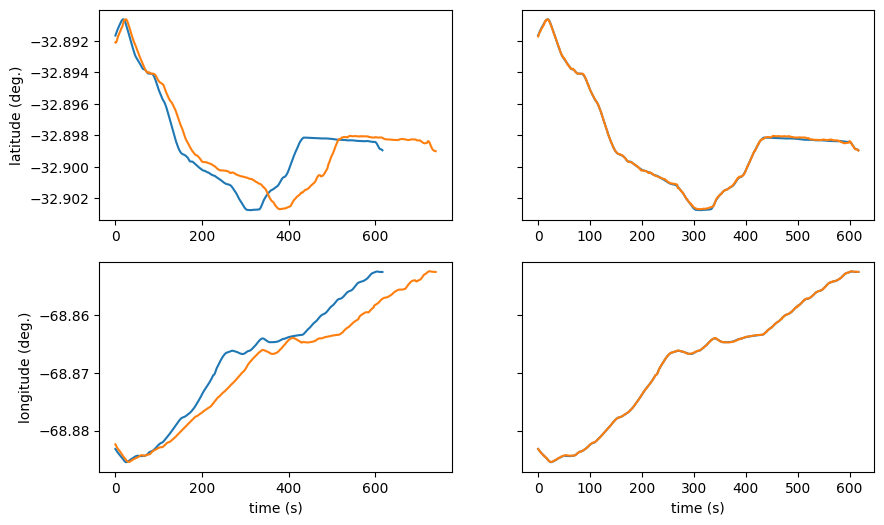

In [140]:
# location matching
loc_orig_df_2_matched = loc_orig_df_1.copy()
for index, row in loc_orig_df_1.iterrows():
    seconds_elapsed_1 = row['seconds_elapsed']
    if index == len(loc_orig_df_2_matched):
        break
    loc_orig_df_2_matched.iloc[index] = loc_orig_df_2.loc[loc_orig_df_2['seconds_elapsed'] == time_matches_dict[seconds_elapsed_1]].values[0]
    

fig, ax = plt.subplots(2, 2, figsize=(10, 6), sharey='row')

ax[0,0].plot(loc_orig_df_1['latitude'].values)
ax[0,0].plot(loc_orig_df_2['latitude'].values)
ax[1,0].plot(loc_orig_df_1['longitude'].values)
ax[1,0].plot(loc_orig_df_2['longitude'].values)

ax[0,1].plot(loc_orig_df_1['latitude'].values)
ax[0,1].plot(loc_orig_df_2_matched['latitude'].values)
ax[1,1].plot(loc_orig_df_1['longitude'].values)
ax[1,1].plot(loc_orig_df_2_matched['longitude'].values)

ax[0,0].set_ylabel('latitude (deg.)')
ax[1,0].set_ylabel('longitude (deg.)')
ax[1,0].set_xlabel('time (s)')
ax[1,1].set_xlabel('time (s)')

# Training

Text(0, 0.5, 'dataset_2')

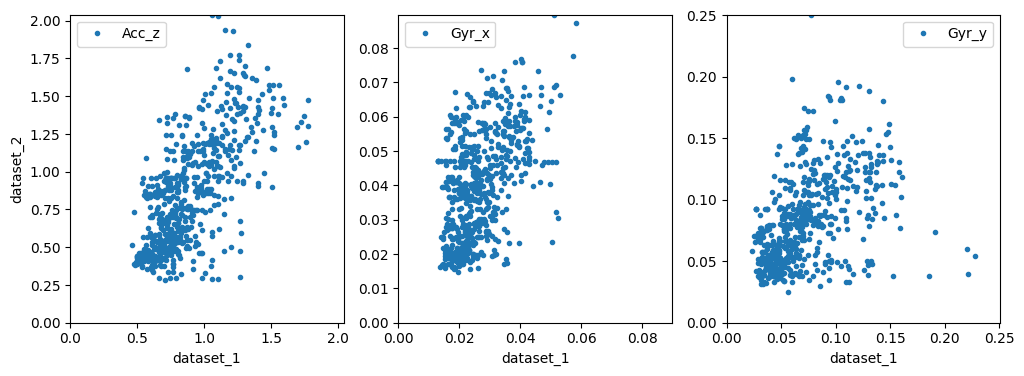

In [141]:
# feature matching
features_lf_2_matched = features_lf_1.copy()
for index, row in features_lf_1.iterrows():
    seconds_elapsed_1 = row['seconds_elapsed']
    features_lf_2_matched.iloc[index] = features_lf_2.loc[features_lf_2['seconds_elapsed'] == time_matches_dict[seconds_elapsed_1]].values[0]
features_lf_2_matched.drop(columns='level_0').reset_index(inplace=True)

# pd.plotting.scatter_matrix(features_lf_1.loc[:, list(vib_features_tol.keys())])
# pd.plotting.scatter_matrix(features_lf_2_matched.loc[:, list(vib_features_tol.keys())])

fig, ax = plt.subplots(1, max(2,n_vib_features), figsize=(4*n_vib_features, 4), sharex='none', sharey='none')
for i, vib_feature in enumerate(vib_features_tol.keys()):
    ax[i].plot(features_lf_1[vib_feature], features_lf_2_matched[vib_feature], label=short_label(vib_feature),
               linestyle='', marker='.')
    ax[i].set_xlim([0, max(np.hstack((features_lf_1[vib_feature], features_lf_2_matched[vib_feature])))])
    ax[i].set_ylim([0, max(np.hstack((features_lf_1[vib_feature], features_lf_2_matched[vib_feature])))])
    ax[i].legend()
    ax[i].set_xlabel('dataset_1')
ax[0].set_ylabel('dataset_2')

### Datasets

In [142]:
X_equal = np.hstack((features_lf_1.loc[:, 'speed'].values.reshape((-1, 1)), features_lf_1.loc[:, list(vib_features_tol.keys())].values, 
                     features_lf_2_matched.loc[:, 'speed'].values.reshape((-1, 1)), features_lf_2_matched.loc[:, list(vib_features_tol.keys())].values))
y_equal = np.zeros((X_equal.shape[0], 1))


#### Ordinal labels

In [143]:
def pareto_dom(x1: np.array, x2: np.array, tols: np.array):
    x1_minus_x2 = x1 - x2
    if np.max(x1_minus_x2 - tols) > 0 and np.min(x1_minus_x2 + tols) > 0:
        return 1.
    elif np.max(-x1_minus_x2 - tols) > 0 and np.min(-x1_minus_x2 + tols) > 0:
        return -1.
    else:
        return None

(array([19.,  0.,  0.,  0.,  0., 32.,  0.,  0.,  0., 10.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

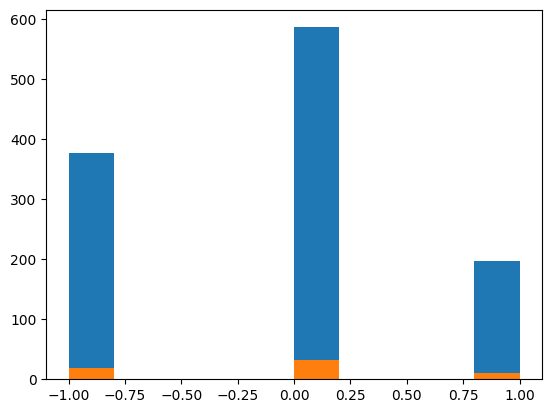

In [144]:
X_ordinal = []
y_ordinal = []
for x1 in X_equal[:, :(1+n_vib_features)]:
    for x2 in X_equal[:, (1+n_vib_features):]:
        if abs(x1[0] - x2[0]) < speed_tol:
            dominance = pareto_dom(x1[1:], x2[1:], list(vib_features_tol.values()))
            if dominance is not None:
                X_ordinal.append(np.hstack((x1, x2)))
                y_ordinal.append(dominance)
X_ordinal = np.array(X_ordinal)
y_ordinal = np.array(y_ordinal).reshape((-1, 1))

X = np.vstack((X_equal, X_ordinal))
y = np.vstack((y_equal, y_ordinal))
shuffler = np.arange(X.shape[0])
np.random.default_rng().shuffle(shuffler)
X = X[shuffler, :]
y = y[shuffler, :]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, shuffle=True)

plt.hist(y_train)
plt.hist(y_test)

## Model definition

In [145]:
import keras


x1_nn_input = keras.layers.Input(shape=(1+n_vib_features,))
x2_nn_input = keras.layers.Input(shape=(1+n_vib_features,))

activation = 'tanh'
reg = 'l2'
dropout = 0.0
shared_layers = [
                #  keras.layers.Dense(64, activation=activation, kernel_regularizer=reg, bias_regularizer=reg, activity_regularizer=reg),
                #  keras.layers.Dropout(dropout),
                #  keras.layers.BatchNormalization(),
                #  keras.layers.Dense(32, activation=activation, kernel_regularizer=reg, bias_regularizer=reg, activity_regularizer=reg),
                #  keras.layers.Dropout(dropout),
                #  keras.layers.BatchNormalization(),
                #  keras.layers.Dense(16, activation=activation, kernel_regularizer=reg, bias_regularizer=reg, activity_regularizer=reg),
                #  keras.layers.Dropout(dropout),
                #  keras.layers.BatchNormalization(),
                 keras.layers.Dense(8, activation=activation, kernel_regularizer=reg, bias_regularizer=reg, activity_regularizer=reg),
                 keras.layers.Dropout(dropout),
                 keras.layers.BatchNormalization(),
                 keras.layers.Dense(4, activation=activation, kernel_regularizer=reg, bias_regularizer=reg, activity_regularizer=reg),
                 keras.layers.Dropout(dropout),
                 keras.layers.BatchNormalization(),
                 keras.layers.Dense(1, activation='linear', kernel_regularizer=reg, bias_regularizer=reg, activity_regularizer=reg)]
first = True
for layer in shared_layers:
    if first:
        x1_nn = layer(x1_nn_input)
        x2_nn = layer(x2_nn_input)
        first = False    
    else:
        x1_nn = layer(x1_nn)
        x2_nn = layer(x2_nn)

y_nn = keras.layers.Lambda(lambda x12: keras.backend.tanh(x12[0] - x12[1]), name='ranker')((x1_nn, x2_nn))

model = keras.models.Model(inputs=[x1_nn_input, x2_nn_input], outputs=[y_nn])
model.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_19 (InputLayer)       [(None, 4)]                  0         []                            
                                                                                                  
 input_20 (InputLayer)       [(None, 4)]                  0         []                            
                                                                                                  
 dense_36 (Dense)            (None, 8)                    40        ['input_19[0][0]',            
                                                                     'input_20[0][0]']            
                                                                                                  
 dropout_27 (Dropout)        (None, 8)                    0         ['dense_36[0][0]',     

In [146]:
model_x1 = keras.models.Model(inputs=[x1_nn_input], outputs=[x1_nn])
model_x1.build(input_shape=x1_nn_input.shape)
# model_x1.summary()

## Model training

Epoch 1/500
1/1 [==============================] - 4s 4s/step - loss: 1.3568 - val_loss: 0.9029 - lr: 0.5000
Epoch 2/500
1/1 [==============================] - 0s 51ms/step - loss: 1.0383 - val_loss: 0.7875 - lr: 0.5000
Epoch 3/500
1/1 [==============================] - 0s 48ms/step - loss: 0.7414 - val_loss: 0.8868 - lr: 0.5000
Epoch 4/500
1/1 [==============================] - 0s 54ms/step - loss: 0.9035 - val_loss: 0.8616 - lr: 0.5000
Epoch 5/500
1/1 [==============================] - 0s 63ms/step - loss: 0.8297 - val_loss: 0.8314 - lr: 0.5000
Epoch 6/500
1/1 [==============================] - 0s 58ms/step - loss: 0.7466 - val_loss: 0.8289 - lr: 0.5000
Epoch 7/500
1/1 [==============================] - 0s 64ms/step - loss: 0.7944 - val_loss: 0.7312 - lr: 0.5000
Epoch 8/500
1/1 [==============================] - 0s 65ms/step - loss: 0.6856 - val_loss: 0.8053 - lr: 0.5000
Epoch 9/500
1/1 [==============================] - 0s 65ms/step - loss: 0.7358 - val_loss: 0.7608 - lr: 0.5000
Epo

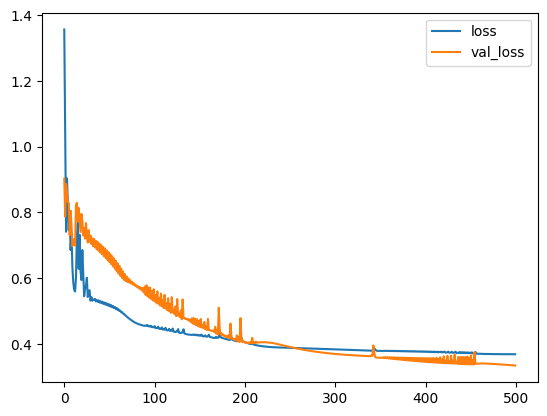

In [147]:
learning_rate = .5
batch_size = X_train.shape[0]
epochs = 500
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7,
                                              patience=5, verbose=1,min_lr=0)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100,)

model.compile(optimizer=keras.optimizers.SGD(learning_rate=learning_rate), loss='mse')
history = model.fit(x=[X_train[:, :(1+n_vib_features)], X_train[:, (1+n_vib_features):]], 
                    y=[y_train], batch_size=batch_size, 
                    epochs=epochs, validation_split=0.1, callbacks=[reduce_lr, early_stopping])
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

## Test

In [148]:
import plotly.graph_objects as go


x1_nn_train_pred = model_x1.predict([X_train[:, :(1+n_vib_features)]])
x1_nn_test_pred = model_x1.predict([X_test[:, :(1+n_vib_features)]])


for i in range(n_vib_features):
    layout = go.Layout(width=800, height=600, title=list(vib_features_tol.keys())[i])
    fig1 = go.Figure(layout=layout)
    fig1.add_trace(go.Scatter3d(x=X_train[:, 0], y=X_train[:, i+1], z=x1_nn_train_pred[:,0],
                                mode='markers', marker=dict(size=5), name='train'))
    fig1.add_trace(go.Scatter3d(x=X_test[:, 0], y=X_test[:, i+1], z=x1_nn_test_pred[:,0],
                                mode='markers', marker=dict(size=5), name='test'))
    fig1.show()


# layout = go.Layout(width=800, height=600)
# X1_mesh, X2_mesh = np.meshgrid(np.linspace(0., 15., 20), np.linspace(0., 2.5, 20))
# x1_mesh, x2_mesh = np.ravel(X1_mesh).reshape((-1, 1)), np.ravel(X2_mesh).reshape((-1, 1))
# X1_mesh = np.hstack((x1_mesh, x2_mesh))
# y_mesh = model_x1.predict([X1_mesh])
# fig4 = go.Figure(data=go.Scatter3d(x=x1_mesh.ravel(), y=x2_mesh.ravel(), z=y_mesh.ravel(),
#                                    mode='markers', marker=dict(size=5)), layout=layout)
# fig4.show()


2/2 [==============================] - 0s 7ms/step


## Robustness testing

20/20 [==============================] - 0s 4ms/step


Text(0.5, 0, 'sample')

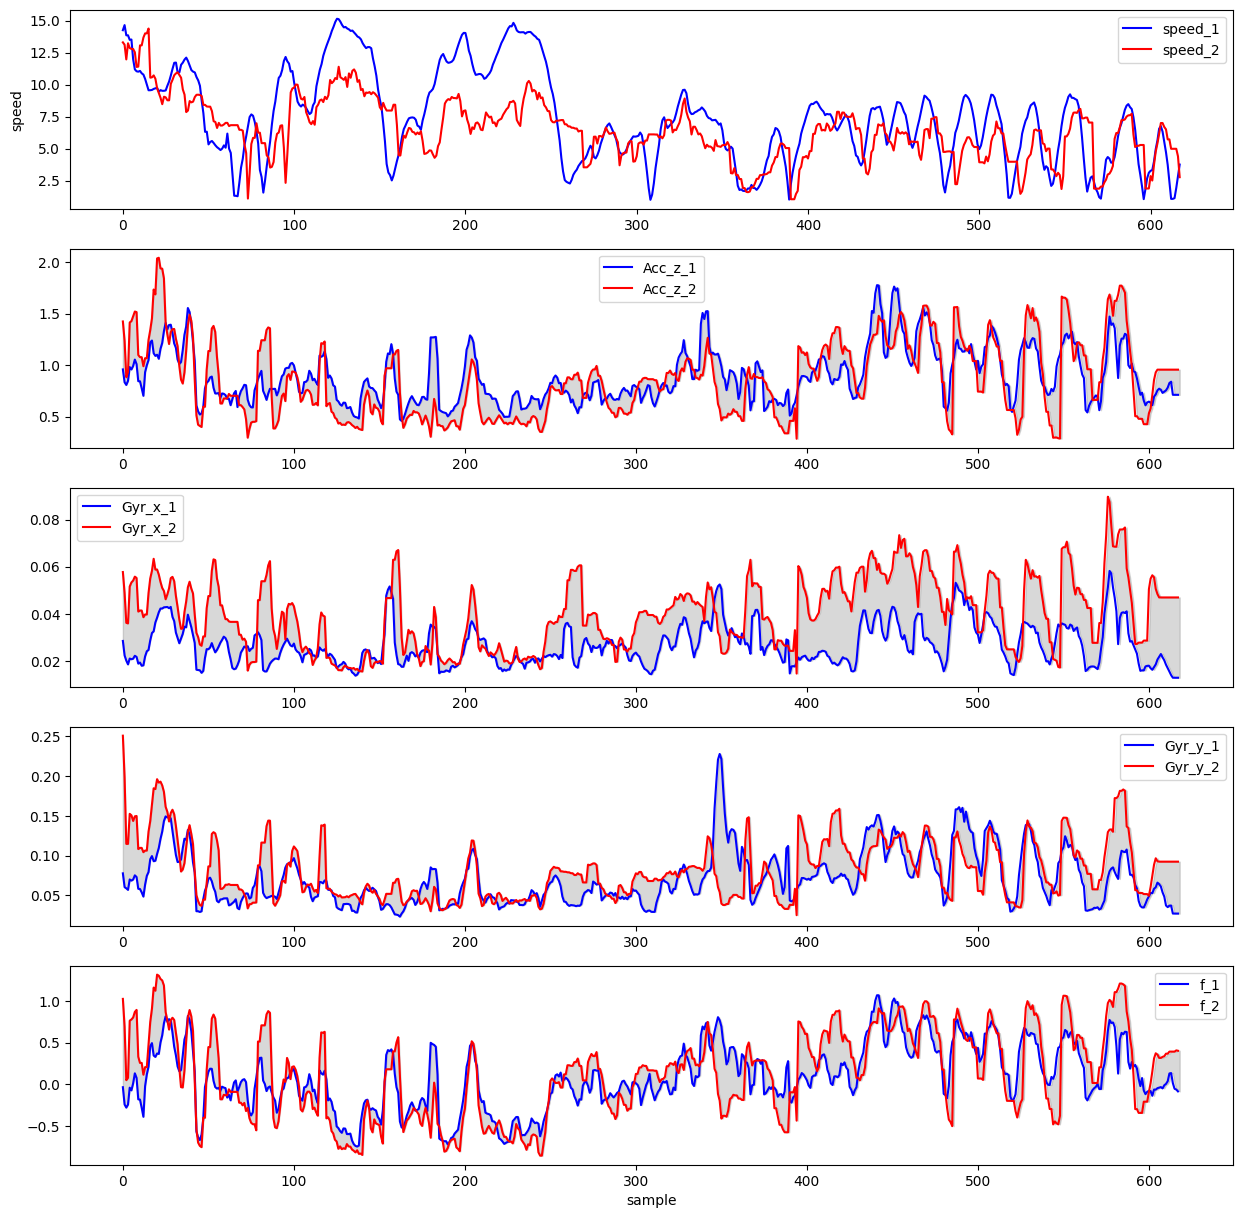

In [149]:
# X_equal = np.array([features_lf_1.loc[:, 'speed'].values, features_lf_1.loc[:, 'z_rolling_rms'].values, 
#               features_lf_2_matched.loc[:, 'speed'].values, features_lf_2_matched.loc[:, 'z_rolling_rms'].values]).T
# y_equal = np.zeros((X_equal.shape[0], 1))

x1_1_pred = model_x1.predict([X_equal[:, :(1+n_vib_features)]])
x1_2_pred = model_x1.predict([X_equal[:, (1+n_vib_features):]])

fig, ax = plt.subplots(2+n_vib_features, 1, figsize=(15, 6+3*n_vib_features))
ax[0].plot(X_equal[:, 0], color='blue', linestyle='-', label='speed_1')
ax[0].plot(X_equal[:, n_vib_features+1], color='red', linestyle='-', label='speed_2')
ax[0].legend()
ax[0].set_ylabel('speed')
for i, vib_feature in enumerate(vib_features_tol.keys()):
    ax[1+i].plot(X_equal[:, 1+i], color='blue', linestyle='-', label=short_label(vib_feature) + '_1')
    ax[1+i].plot(X_equal[:, 2+n_vib_features+i], color='red', linestyle='-', label=short_label(vib_feature) + '_2')
    ax[1+i].fill_between(np.linspace(0,x1_1_pred.shape[0],x1_1_pred.shape[0]), 
                   (X_equal[:, 1+i]).ravel(), 
                   (X_equal[:, 2+n_vib_features+i]).ravel(), 
                   color='grey', alpha=0.3)  # Adjust alpha for transparency if needed
    ax[1+i].legend()
ax[2+i].plot(x1_1_pred, color='blue', linestyle='-', label='f_1')
ax[2+i].plot(x1_2_pred, color='red', linestyle='-', label='f_2')
ax[2+i].fill_between(np.linspace(0,x1_1_pred.shape[0],x1_1_pred.shape[0]), 
                   (x1_1_pred).ravel(), 
                   (x1_2_pred).ravel(), 
                   color='grey', alpha=0.3)  # Adjust alpha for transparency if needed
ax[2+i].legend()
ax[2+i].set_xlabel('sample')


In [150]:
circ_rad = 10

# Create a map centered at the mean latitude and longitude of loc_orig_df_2
center_lat = loc_orig_df_1['latitude'].mean()
center_lon = loc_orig_df_1['longitude'].mean()
mymap = folium.Map(location=[center_lat, center_lon], zoom_start=10, tiles='OpenStreetMap')

f1, f2 = x1_1_pred[:,0], x1_2_pred[:,0]
f1, f2 = f1-np.min(f1), f2-np.min(f2)
f1, f2 = f1/np.max(f1), f2/np.max(f2)

# Plot the latitude and longitude data on the map
for index in range(loc_orig_df_1.shape[0]):
    row1, row2 = loc_orig_df_1.iloc[index,:], loc_orig_df_2_matched.iloc[index,:]
    folium.Circle([row1['latitude'], row1['longitude']],
                        radius=circ_rad*f1[index],
                        color='blue',
                        fill=False,
                        fill_color='blue').add_to(mymap)
    folium.Circle([row2['latitude'], row2['longitude']],
                        radius=circ_rad*f2[index],
                        color='red',
                        fill=False,
                        fill_color='red').add_to(mymap)

# Save the map to an HTML file
mymap.save("map_multi_f.html")



In [151]:
circ_rad = 5

# Create a map centered at the mean latitude and longitude of loc_orig_df_2
center_lat = loc_orig_df_1['latitude'].mean()
center_lon = loc_orig_df_1['longitude'].mean()
mymap = folium.Map(location=[center_lat, center_lon], zoom_start=10, tiles='OpenStreetMap')

vib_norm = {_: None for _ in vib_features_tol.keys()}
for i, vib_feature in enumerate(vib_features_tol.keys()):
    vib1, vib2 = X_equal[:, 1+i], X_equal[:, 2+n_vib_features]
    vib1, vib2 = vib1-np.min(vib1), vib2-np.min(vib2)
    vib1, vib2 = vib1/np.max(vib1), vib2/np.max(vib2)
    vib_norm[vib_feature] = [vib1, vib2]

    # Plot the latitude and longitude data on the map
    for index in range(loc_orig_df_1.shape[0]):
        row1, row2 = loc_orig_df_1.iloc[index,:], loc_orig_df_2_matched.iloc[index,:]
        folium.Circle([row1['latitude'], row1['longitude']],
                            radius=circ_rad*vib1[index],
                            color='blue',
                            fill=False,
                            fill_color='blue').add_to(mymap)
        folium.Circle([row2['latitude'], row2['longitude']],
                            radius=circ_rad*vib2[index],
                            color='red',
                            fill=False,
                            fill_color='red').add_to(mymap)

    # Save the map to an HTML file
    mymap.save(f"map_multi_vib_{vib_feature}.html")

### Correlations

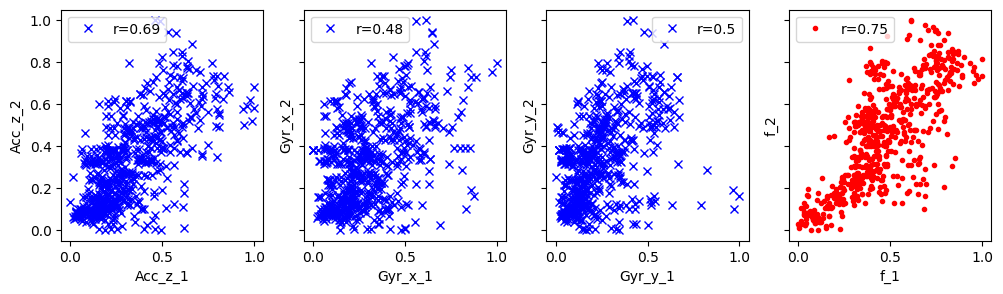

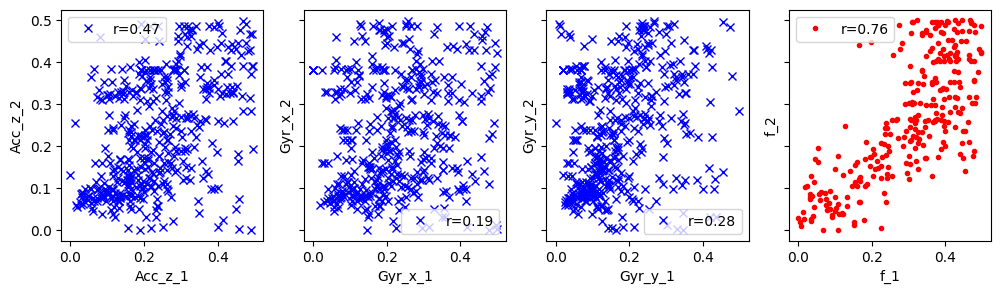

In [152]:
# vibration correlation
fig, ax = plt.subplots(1, 1+n_vib_features, figsize=(3*(1+n_vib_features), 3), sharex='all', sharey='all')
for i, vib_feature in enumerate(vib_features_tol.keys()):
    vib1, vib2 = vib_norm[vib_feature]
    ax[i].plot(vib1, vib2, linestyle='', color='blue', marker='x', label=f'r={np.round(np.corrcoef(vib1, vib2)[1,0], 2)}')
    ax[i].set_xlabel(f'{short_label(vib_feature)}_1')
    ax[i].set_ylabel(f'{short_label(vib_feature)}_2')
    ax[i].legend()
ax[i+1].plot(f1, f2, linestyle='', color='red', marker='.', label=f'r={np.round(np.corrcoef(f1, f2)[1,0], 2)}')
ax[i+1].set_xlabel('f_1')
ax[i+1].set_ylabel('f_2')
ax[i+1].legend()
plt.show()

fig, ax = plt.subplots(1, 1+n_vib_features, figsize=(3*(1+n_vib_features), 3), sharex='all', sharey='all')
for i, vib_feature in enumerate(vib_features_tol.keys()):
    vib1, vib2 = vib_norm[vib_feature]
    vib_low = np.vstack((vib1, vib2)).T
    vib_low = vib_low[(vib_low[:, 0] < 0.5) & (vib_low[:, 1] < 0.5), :]
    vib1_low, vib2_low = vib_low[:, 0], vib_low[:, 1]
    f_low = np.vstack((f1, f2)).T
    f_low = f_low[(f_low[:, 0] < 0.5) & (f_low[:, 1] < 0.5), :]
    f1_low, f2_low = f_low[:, 0], f_low[:, 1]

    ax[i].plot(vib1_low, vib2_low, linestyle='', color='blue', marker='x', label=f'r={np.round(np.corrcoef(vib1_low, vib2_low)[1,0], 2)}')
    ax[i].set_xlabel(f'{short_label(vib_feature)}_1')
    ax[i].set_ylabel(f'{short_label(vib_feature)}_2')
    ax[i].legend()
ax[i+1].plot(f1_low, f2_low, linestyle='', color='red', marker='.', label=f'r={np.round(np.corrcoef(f1_low, f2_low)[1,0], 2)}')
ax[i+1].set_xlabel('f_1')
ax[i+1].set_ylabel('f_2')
ax[i+1].legend()
plt.show()
